In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
np.set_printoptions(precision=2)
%matplotlib inline

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 8.1 ノンパラメトリック統計学

## 8.2 カーネルベースモデル
### 8.2.1 ガウスカーネル
$K(x, x') = exp(- \frac{\Vert x - x' \Vert^2}{\omega})$

### コード8.1 分析に使う人工的な合成データを作成する

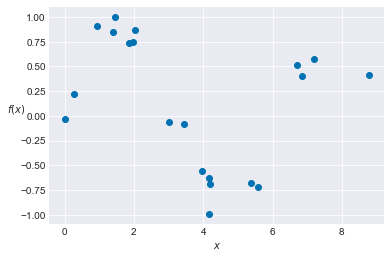

In [2]:
np.random.seed(1)
x = np.random.uniform(0, 10, size=20)
y = np.random.normal(np.sin(x), 0.2)
plt.plot(x, y, 'o')
plt.xlabel('$x$')
plt.ylabel('$f(x)$', rotation=0)

### コード8.2 カーネルモデルのKDEとトレースを出力する

In [3]:
def gauss_kernel(x, n_knots):
    """
    Simple Gaussian radial kernel
    """
    knots = np.linspace(x.min(), x.max(), n_knots)
    w = 2
    return np.array([np.exp(-(x-k)**2/w) for k in knots])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, gamma]
100%|██████████| 5500/5500 [00:08<00:00, 651.24it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fe31710>,
      dtype=object)

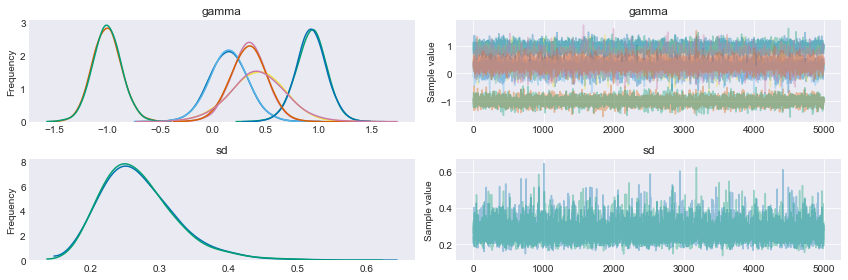

In [4]:
n_knots = 5

with pm.Model() as kernel_model:
    gamma = pm.Cauchy('gamma', alpha=0, beta=1, shape=n_knots)
    sd = pm.Uniform('sd', 0, 10)
    mu = pm.math.dot(gamma, gauss_kernel(x, n_knots))
    yl = pm.Normal('yl', mu=mu, sd=sd, observed=y)
    
    kernel_trace = pm.sample(5000, njobs=1)
    
pm.traceplot(kernel_trace)

### コード8.4 カーネルモデルの事後予測をチェックする

100%|██████████| 100/100 [00:01<00:00, 99.26it/s]


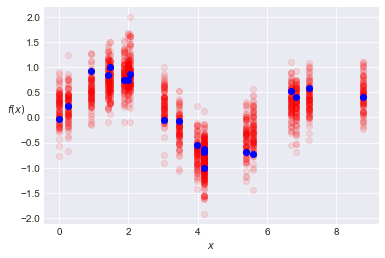

In [5]:
ppc = pm.sample_ppc(kernel_trace, model=kernel_model, samples=100)
plt.plot(x, ppc['yl'].T, 'ro', alpha=0.1)

plt.plot(x, y, 'bo')
plt.xlabel('$x$')
plt.ylabel('$f(x)$', rotation=0)

### コード8.5 カーネルモデルのデータとの適合性を確認する

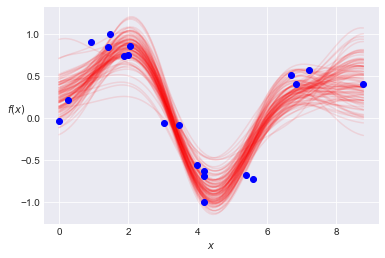

In [6]:
new_x = np.linspace(x.min(), x.max(), 100)
k = gauss_kernel(new_x, n_knots)
gamma_pred = kernel_trace['gamma']
for i in range(100):
    idx = np.random.randint(0, len(gamma_pred))
    y_pred = np.dot(gamma_pred[idx], k)
    plt.plot(new_x, y_pred, 'r-', alpha=0.1)
plt.plot(x, y, 'bo')
plt.xlabel('$x$')
plt.ylabel('$f(x)$', rotation=0)

In [8]:
gamma_pred.shape

(10000, 5)

In [11]:
k.shape

(5, 100)

## 8.3 ガウス過程

### コード8.6 GPの事前分布から任意の６個の関数を出力する

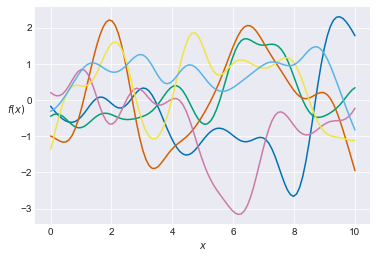

In [26]:
squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])
np.random.seed(1)
test_points = np.linspace(0, 10, 100)
cov = np.exp(-squared_distance(test_points, test_points))
plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=6).T)
plt.xlabel('$x$')
plt.ylabel('$f(x)$', rotation=0)

### コード8.7 あらかじめ指定したハイパーパラメータでガウス過程のグラフを出力する

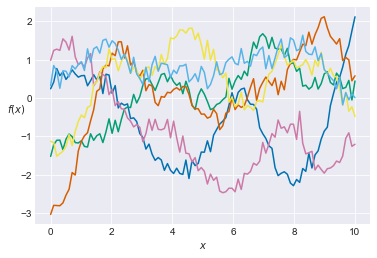

In [28]:
np.random.seed(1)
eta = 1
rho = 0.5
sigma = 0.03

D = squared_distance(test_points, test_points)
cov = eta * np.exp(-rho * D)
diag = eta + sigma
np.fill_diagonal(cov, diag)

for i in range(6):
    plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov))
    
plt.xlabel('$x$')
plt.ylabel('$f(x)$', rotation=0)

### コード8.8 逆行列を使ったGP事後分布から具現化曲線を例示する

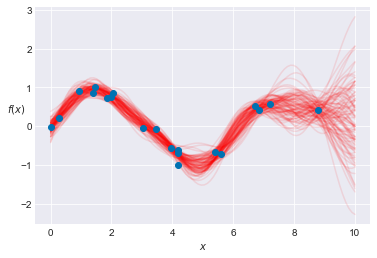

In [31]:
np.random.seed(1)
K_oo = eta * np.exp(-rho * D)
D_x = squared_distance(x, x)
K = eta * np.exp(-rho * D_x)
diag_x = eta + sigma
np.fill_diagonal(K, diag)

D_off_diag = squared_distance(x, test_points)
K_o = eta * np.exp(-rho * D_off_diag)

mu_post = np.dot(np.dot(K_o, np.linalg.inv(K)), y)
SIGMA_post = K_oo - np.dot(np.dot(K_o,np.linalg.inv(K)), K_o.T)

for i in range(100):
    fx = stats.multivariate_normal.rvs(mean=mu_post, cov=SIGMA_post)
    plt.plot(test_points, fx, 'r-', alpha=0.1)
    
plt.plot(x, y, 'o')
plt.xlabel('$x$')
plt.ylabel('$f(x)$', rotation=0)

### コード8.9 コレスキー分解を使ったGP事後分布から平均関数と不確実性を描く

In [32]:
np.random.seed(1)
eta = 1
rho = 0.5
sigma = 0.03

f = lambda x: np.sin(x).flatten()

def kernel(a, b):
    """ GP squared exponential kernel"""
    kernelParmeter = 0.1
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2 * np.dot(a, b.T)
    
    return eta * np.exp(- rho * sqdist)

N = 20
n = 100

X = np.random.uniform(0, 10, size=(N, 1))
yfx = f(X) + sigma * np.random.randn(N)

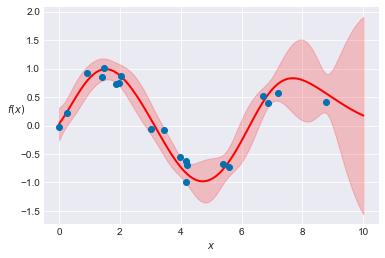

In [42]:
K = kernel(X, X)
L = np.linalg.cholesky(K + sigma * np.eye(N))

Xtest = np.linspace(0, 10, n).reshape(-1, 1)

Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, yfx))

K_ = kernel(Xtest, Xtest)
sd_pred = (np.diag(K_) - np.sum(Lk**2, axis=0))**0.5

plt.fill_between(Xtest.flat, mu - 2 * sd_pred, mu + 2 * sd_pred, color='r', alpha=0.2)

plt.plot(Xtest, mu, 'r', lw=2)
plt.plot(x, y, 'o')
plt.xlabel('$x$')
plt.ylabel('$f(x)$', rotation=0)

- GP事前分布：$f(x) \sim GP(\mu = [0\cdots0], k(x, x'))$
- 正規分布による尤度： $p(y|x,f(x)) \sim N({\bf f}, \sigma^2I)$
- GP事後分布：$p(f(x)|x,y) \sim GP(\mu_{post},\Sigma_{post})$
### コード8.10 ガウス過程におけるハイパーパラメータをPyMC3で推論する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, rho, eta]
 75%|███████▍  | 1123/1500 [00:09<00:03, 112.34it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 1500/1500 [00:10<00:00, 138.49it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132fe8cf8>,
      dtype=object)

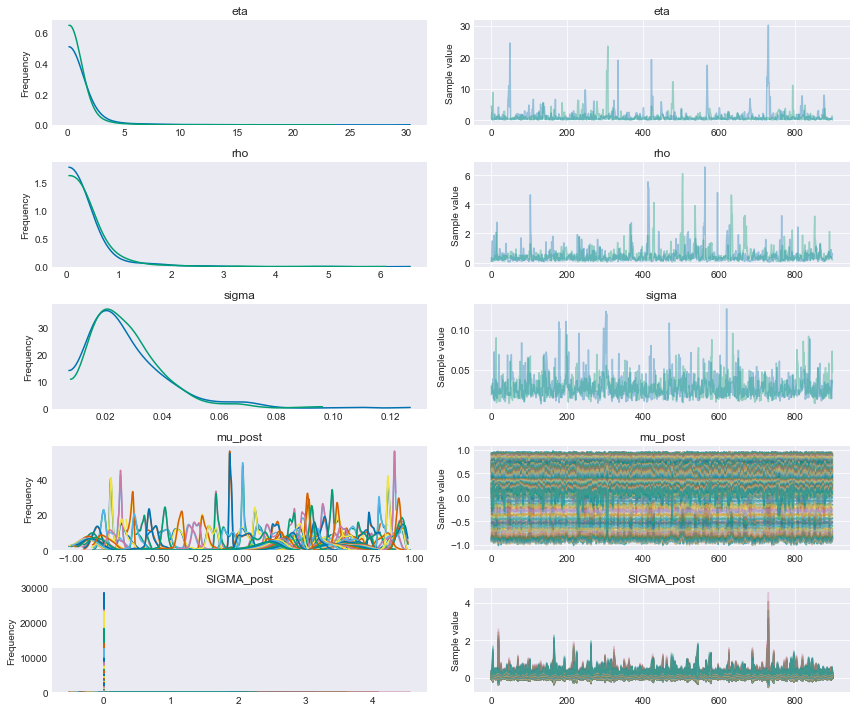

In [43]:
with pm.Model() as GP:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    D = squared_distance(x, x)
    K = tt.fill_diagonal(eta * pm.math.exp(-rho * D), eta + sigma)
    
    obs = pm.MvNormal('obs', mu, cov=K, observed=y)
    test_points = np.linspace(0, 10, 100)
    D_pred = squared_distance(test_points, test_points)
    D_off_diag = squared_distance(x, test_points)
    
    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)
    
    mu_post = pm.Deterministic('mu_post', pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
    SGMA_post = pm.Deterministic('SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o,tt.nlinalg.matrix_inverse(K)), K_o.T))
    
    trace = pm.sample(1000, njobs=1)
    
varnames = ['eta', 'rho', 'sigma']
chain = trace[100:]
pm.traceplot(chain, varnames)

In [44]:
pm.summary(chain, varnames).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
eta,1.1790,2.0814,0.0915,0.1195,3.6407,460.0673,1.0055
rho,0.4741,0.5750,0.0198,0.0390,1.3999,606.2549,1.0001
sigma,0.0284,0.0148,0.0005,0.0085,0.0582,794.0108,1.0002


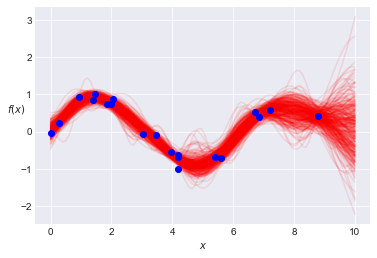

In [45]:
# 事後予測チェック
y_pred = [np.random.multivariate_normal(m, S) for m, S in zip(chain['mu_post'][::5], chain['SIGMA_post'][::5])]

for yp in y_pred:
    plt.plot(test_points, yp, 'r-', alpha=0.1)
    
plt.plot(x, y, 'bo')
plt.xlabel('$x$')
plt.ylabel('$f(x)$', rotation=0)

### コード8.13 周期カーネルを組み込んだGP事後分布から具現化曲線を描く

In [46]:
periodic = lambda x, y: np.array([[np.sin((x[i] - y[j])/2)**2 for i in range(len(x))] for j in range(len(y))])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, rho, eta]
 71%|███████   | 1062/1500 [00:09<00:04, 106.80it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 1500/1500 [00:11<00:00, 134.32it/s]
The acceptance probability does not match the target. It is 0.8799401596363763, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1725f05f8>,
      dtype=object)

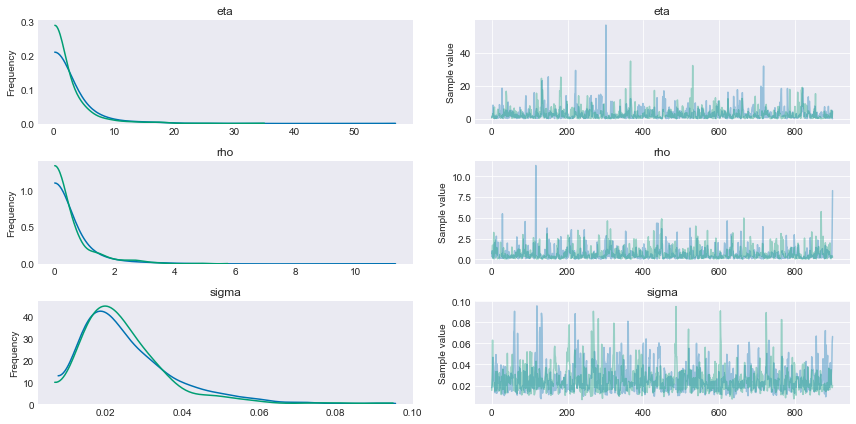

In [47]:
with pm.Model() as GP_periodic:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    P = periodic(x, x)
    K = tt.fill_diagonal(eta * pm.math.exp(-rho * P), eta + sigma)
    
    obs = pm.MvNormal('obs', mu, cov=K, observed=y)
    test_points = np.linspace(0, 10, 100)
    D_pred = periodic(test_points, test_points)
    D_off_diag = periodic(x, test_points)
    
    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)
    
    mu_post = pm.Deterministic('mu_post', pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
    SGMA_post = pm.Deterministic('SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o,tt.nlinalg.matrix_inverse(K)), K_o.T))
    
    trace = pm.sample(1000, njobs=1)
    
varnames = ['eta', 'rho', 'sigma']
chain = trace[100:]
pm.traceplot(chain, varnames)

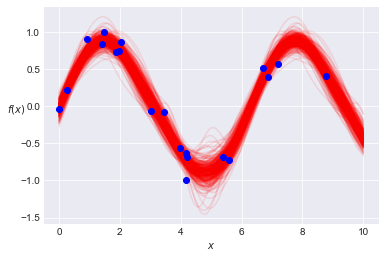

In [48]:
# 事後予測チェック
y_pred = [np.random.multivariate_normal(m, S) for m, S in zip(chain['mu_post'][::5], chain['SIGMA_post'][::5])]

for yp in y_pred:
    plt.plot(test_points, yp, 'r-', alpha=0.1)
    
plt.plot(x, y, 'bo')
plt.xlabel('$x$')
plt.ylabel('$f(x)$', rotation=0)